In [9]:
import scanpy as sc
import cfp.preprocessing as cfpp

/home/icb/dominik.klein/mambaforge/envs/cfp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
split = 5

In [4]:
adata = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/sciplex/pca_attention_pooling/adata_ood_with_predictions_{split}.h5ad")


In [6]:
ood_split = 5

In [69]:
adata_train_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_train_{ood_split}.h5ad"
adata_test_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_test_{ood_split}.h5ad"
adata_ood_path = f"/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/adata_ood_{ood_split}.h5ad"

adata_train = sc.read(adata_train_path)
adata_test = sc.read(adata_test_path)
adata_ood = sc.read(adata_ood_path)
adata_pred_test = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/sciplex/pca_attention_pooling/adata_test_with_predictions_{split}.h5ad")
adata_pred_ood = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/sciplex/pca_attention_pooling/adata_ood_with_predictions_{split}.h5ad")

adata_ref_ood = adata_test#[~adata_ood.obs["condition"].str.contains('Vehicle')].copy()




In [72]:
adata_ref_ood = adata_test

In [73]:
cfpp.centered_pca(adata_ref_ood, n_comps=10)

cfpp.project_pca(query_adata=adata_pred_ood, ref_adata=adata_ref_ood)
cfpp.project_pca(query_adata=adata_ood, ref_adata=adata_ref_ood)
ood_data_target_encoded = {}
ood_data_target_decoded = {}
ood_data_target_encoded_predicted = {}
ood_data_target_decoded_predicted = {}
for cond in adata_ood.obs["condition"].cat.categories:
    if "Vehicle" in cond:
        continue
    ood_data_target_encoded[cond] = adata_ood[adata_ood.obs["condition"] == cond].obsm["X_pca"]
    ood_data_target_decoded[cond] = adata_ood[adata_ood.obs["condition"] == cond].X.toarray()
    ood_data_target_decoded_predicted[cond] = adata_pred_ood[adata_pred_ood.obs["condition"] == cond].layers["X_recon_pred"]
    ood_data_target_encoded_predicted[cond] = adata_pred_ood[adata_pred_ood.obs["condition"] == cond].obsm["X_pca"]



In [74]:
ood_metrics_encoded = jax.tree_util.tree_map(
    compute_metrics_fast, ood_data_target_encoded, ood_data_target_encoded_predicted
)
mean_ood_metrics_encoded = compute_mean_metrics(ood_metrics_encoded, prefix="encoded_ood_")
mean_ood_metrics_encoded

{'encoded_ood_r_squared': -1.44624625618269,
 'encoded_ood_e_distance': 57.1014977789809,
 'encoded_ood_mmd_distance': 0.8470103632972901}

In [71]:
ood_metrics_encoded = jax.tree_util.tree_map(
    compute_metrics_fast, ood_data_target_encoded, ood_data_target_encoded_predicted
)
mean_ood_metrics_encoded = compute_mean_metrics(ood_metrics_encoded, prefix="encoded_ood_")
mean_ood_metrics_encoded

{'encoded_ood_r_squared': -1.3543542081409534,
 'encoded_ood_e_distance': 60.28515036152652,
 'encoded_ood_mmd_distance': 0.8586312058460281}

In [13]:
import jax
import functools
import jax
import numpy as np
import scanpy as sc
import cfp.preprocessing as cfpp
from cfp.metrics import compute_mean_metrics, compute_metrics, compute_metrics_fast
import os
import pandas as pd
ood_metrics_encoded = jax.tree_util.tree_map(
    compute_metrics_fast, ood_data_target_encoded, ood_data_target_encoded_predicted
)
mean_ood_metrics_encoded = compute_mean_metrics(ood_metrics_encoded, prefix="encoded_ood_")
mean_ood_metrics_encoded

{'encoded_ood_r_squared': -1.360207610024343,
 'encoded_ood_e_distance': 60.33727873733648,
 'encoded_ood_mmd_distance': 0.8656189614031689}

In [14]:
ood_metrics_decoded = jax.tree_util.tree_map(
    compute_metrics_fast, ood_data_target_decoded, ood_data_target_decoded_predicted
)
mean_ood_metrics_decoded = compute_mean_metrics(ood_metrics_decoded, prefix="decoded_ood_")

In [15]:
mean_ood_metrics_decoded

{'decoded_ood_r_squared': 0.8707174134523534,
 'decoded_ood_e_distance': 8.510432576031794,
 'decoded_ood_mmd_distance': 0.019268459012081105}

In [16]:
adata = sc.read(f"/lustre/groups/ml01/workspace/ot_perturbation/models/otfm/sciplex/pca_attention_pooling/adata_ood_with_predictions_{split}.h5ad")
adata.X = adata.layers["X_recon_pred"]
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

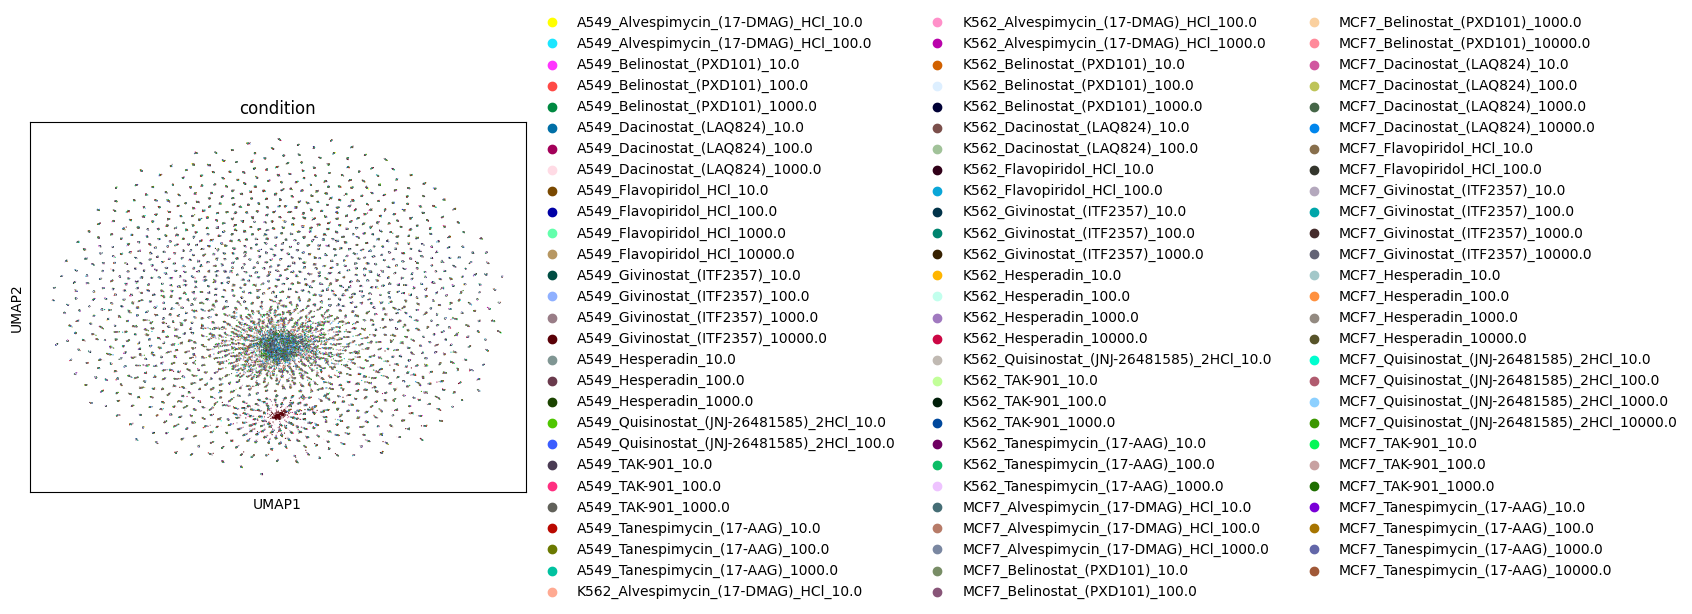

In [17]:
sc.pl.umap(adata, color="condition")

In [37]:

bdata = adata[adata.obs["condition"].str.contains("MCF7_Dacinostat_")]

In [34]:
adata.obs["condition"].value_counts()

condition
A549_Alvespimycin_(17-DMAG)_HCl_10.0    500
MCF7_Flavopiridol_HCl_10.0              500
MCF7_Dacinostat_(LAQ824)_1000.0         500
MCF7_Dacinostat_(LAQ824)_100.0          500
MCF7_Dacinostat_(LAQ824)_10.0           500
                                       ... 
A549_Tanespimycin_(17-AAG)_1000.0       500
A549_Tanespimycin_(17-AAG)_100.0        500
A549_Tanespimycin_(17-AAG)_10.0         500
A549_TAK-901_1000.0                     500
MCF7_Tanespimycin_(17-AAG)_10000.0      500
Name: count, Length: 83, dtype: int64

In [38]:
bdata

View of AnnData object with n_obs × n_vars = 2000 × 2001
    obs: 'condition'
    uns: 'pca', 'neighbors', 'umap', 'condition_colors'
    obsm: 'X_pca_pred', 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'X_recon_pred'
    obsp: 'distances', 'connectivities'

In [42]:
adata_ood.obs["condition"].value_counts()

condition
MCF7_Vehicle_0.0                             500
A549_Vehicle_0.0                             500
K562_Vehicle_0.0                             500
MCF7_Givinostat_(ITF2357)_10.0               499
MCF7_Givinostat_(ITF2357)_100.0              491
                                            ... 
A549_Dacinostat_(LAQ824)_1000.0              108
K562_Alvespimycin_(17-DMAG)_HCl_1000.0       106
A549_Hesperadin_100.0                        105
K562_Quisinostat_(JNJ-26481585)_2HCl_10.0    104
K562_Dacinostat_(LAQ824)_100.0               100
Name: count, Length: 86, dtype: int64

In [62]:
adata_ctrl = adata_ood[adata_ood.obs["condition"].isin(("MCF7_Vehicle_0.0", "MCF7_Dacinostat_(LAQ824)_10.0", "MCF7_Dacinostat_(LAQ824)_100.0", "MCF7_Dacinostat_(LAQ824)_1000.0", "MCF7_Dacinostat_(LAQ824)_10000.0"))]



In [63]:
adata_ctrl.obs["condition"] = adata_ctrl.obs.apply(lambda x: x["condition"]+"_",axis=1)

/tmp/ipykernel_1532956/1983368512.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_ctrl.obs["condition"] = adata_ctrl.obs.apply(lambda x: x["condition"]+"_",axis=1)


In [64]:
import anndata as ad
bdata.var_names = adata_ctrl.var_names
cdata = ad.concat((adata_ctrl, bdata))

In [65]:
cdata

AnnData object with n_obs × n_vars = 4067 × 2001
    obs: 'condition'
    obsm: 'X_pca'

In [66]:
sc.pp.pca(cdata)
sc.pp.neighbors(cdata)
sc.tl.umap(cdata)

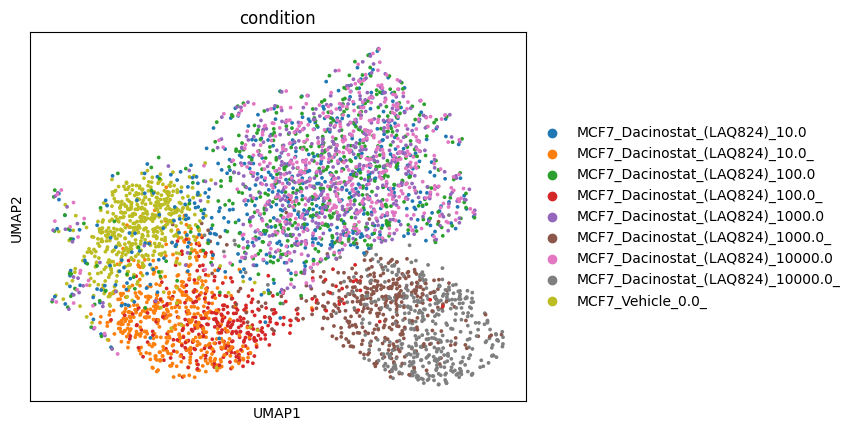

In [67]:
sc.pl.umap(cdata, color="condition")

In [68]:
ood_metrics_encoded

{'A549_Alvespimycin_(17-DMAG)_HCl_10.0': {'r_squared': -0.8475604088079236,
  'e_distance': 74.82401613258668,
  'mmd_distance': 0.9246828},
 'A549_Alvespimycin_(17-DMAG)_HCl_100.0': {'r_squared': -1.1215209630243517,
  'e_distance': 89.91282934873098,
  'mmd_distance': 0.95831877},
 'A549_Belinostat_(PXD101)_10.0': {'r_squared': -1.022036706200904,
  'e_distance': 80.89888872471407,
  'mmd_distance': 0.917336},
 'A549_Belinostat_(PXD101)_100.0': {'r_squared': -1.11699625676414,
  'e_distance': 81.9123623116565,
  'mmd_distance': 0.9223061},
 'A549_Belinostat_(PXD101)_1000.0': {'r_squared': -1.4577141375960174,
  'e_distance': 95.84733556706855,
  'mmd_distance': 0.9573045},
 'A549_Dacinostat_(LAQ824)_10.0': {'r_squared': -1.4612751062469589,
  'e_distance': 89.94289657708077,
  'mmd_distance': 0.9388922},
 'A549_Dacinostat_(LAQ824)_100.0': {'r_squared': -1.7691564057745133,
  'e_distance': 72.33416573979635,
  'mmd_distance': 0.893353},
 'A549_Dacinostat_(LAQ824)_1000.0': {'r_squared'

In [61]:
ood_metrics_decoded

{'A549_Alvespimycin_(17-DMAG)_HCl_10.0': {'r_squared': 0.9711654884479307,
  'e_distance': 2.299344845392497,
  'mmd_distance': 0.0073751784},
 'A549_Alvespimycin_(17-DMAG)_HCl_100.0': {'r_squared': 0.8853796824788432,
  'e_distance': 11.260770355047342,
  'mmd_distance': 0.021993846},
 'A549_Belinostat_(PXD101)_10.0': {'r_squared': 0.9781759201900612,
  'e_distance': 1.8898184837958212,
  'mmd_distance': 0.0077859648},
 'A549_Belinostat_(PXD101)_100.0': {'r_squared': 0.9636478146308232,
  'e_distance': 3.1746068155034237,
  'mmd_distance': 0.0091282},
 'A549_Belinostat_(PXD101)_1000.0': {'r_squared': 0.8679473572616365,
  'e_distance': 13.582371719842172,
  'mmd_distance': 0.021989107},
 'A549_Dacinostat_(LAQ824)_10.0': {'r_squared': 0.9181594973955429,
  'e_distance': 7.756703716218354,
  'mmd_distance': 0.015177753},
 'A549_Dacinostat_(LAQ824)_100.0': {'r_squared': 0.8324713682772822,
  'e_distance': 13.337673810825862,
  'mmd_distance': 0.022433901},
 'A549_Dacinostat_(LAQ824)_1000

In [39]:
sc.pp.neighbors(bdata)
sc.tl.umap(bdata)

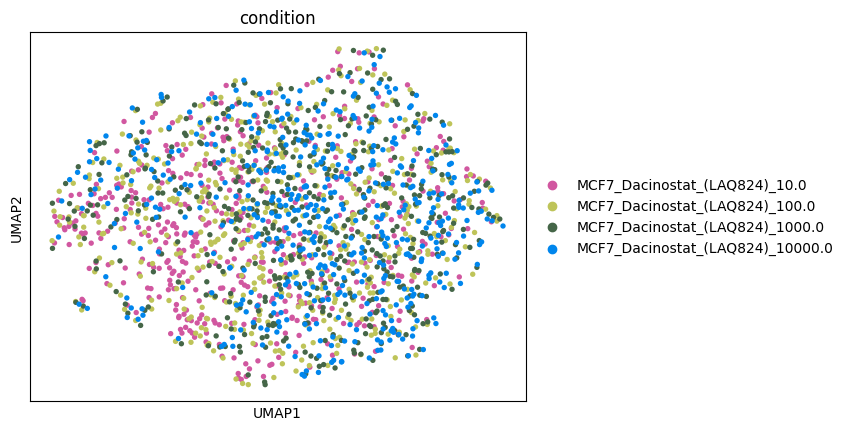

In [40]:
sc.pl.umap(bdata, color="condition")

In [19]:
adata.obs.head()

,condition
0,A549_Alvespimycin_(17-DMAG)_HCl_10.0
1,A549_Alvespimycin_(17-DMAG)_HCl_10.0
2,A549_Alvespimycin_(17-DMAG)_HCl_10.0
3,A549_Alvespimycin_(17-DMAG)_HCl_10.0
4,A549_Alvespimycin_(17-DMAG)_HCl_10.0


In [ ]:




ood_metrics_encoded = jax.tree_util.tree_map(
    compute_metrics_fast, ood_data_target_encoded, ood_data_target_encoded_predicted
)
mean_ood_metrics_encoded = compute_mean_metrics(ood_metrics_encoded, prefix="encoded_ood_")

ood_metrics_decoded = jax.tree_util.tree_map(
    compute_metrics, ood_data_target_decoded, ood_data_target_decoded_predicted
)
mean_ood_metrics_decoded = compute_mean_metrics(ood_metrics_decoded, prefix="decoded_ood_")


output_dir = "/lustre/groups/ml01/workspace/ot_perturbation/data/sciplex/results/otfm/pca_mean_pooling"


split = ood_split
pd.DataFrame.from_dict(ood_metrics_encoded).to_csv(os.path.join(output_dir, f"ood_metrics_encoded_{split}.csv"))
pd.DataFrame.from_dict(ood_metrics_decoded).to_csv(os.path.join(output_dir, f"ood_metrics_decoded_{split}.csv"))
pd.DataFrame.from_dict(deg_ood_metrics).to_csv(os.path.join(output_dir, f"ood_metrics_ood_{split}.csv"))
